---
**Project**: Cable Burial Operability  
**Author**: Alejandra L. Cameselle  
**Date**: June 2025  
**Notebook**: 06 – Route Risk Assessment Based on Operational Complexity

### Description
This notebook evaluates the operational complexity along a simulated submarine cable route by intersecting it with previously classified grid cells. Each segment of the route is assigned a risk score based on burial feasibility.

### Inputs
- `05_grid_operational_complexity.gpkg`: Grid with assigned operational complexity classes
- `simulated_routes.gpkg`: LineString representing a candidate cable route

### Processing
- Intersect route with complexity grid
- Segment route by complexity class
- Calculate risk statistics (length and % by class)
- Generate visual maps and summary tables

### Outputs
- `06_route_segments_by_complexity.gpkg`: Route split by risk classes
- `06_route_segments_by_risk.png`: Visual plot of segmented route
- Summary table (km and %) per class

### Assumptions
- Route input contains a single LineString geometry
- CRS is consistent across layers (EPSG:4326 input, EPSG:25829 for length)

### Dependencies
- geopandas, pandas, matplotlib
---


In [1]:
# Standard libraries
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set plot style
plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
# Load data
grid = gpd.read_file("../processed_data/05_grid_operational_complexity.gpkg", layer="05_grid_operational_complexity")
route = gpd.read_file("../inputs/simulated_routes.gpkg")

In [3]:
# Intersect route with complexity grid
intersections = gpd.overlay(grid, route, how="intersection", keep_geom_type=False)

In [4]:
# Assign risk scores
risk_points = {"Low": 0, "Moderate": 1, "High": 2, "Critical": 3}
intersections["risk_score"] = intersections["cell_complexity"].map(risk_points)

In [5]:
# Calculate segment lengths
intersections = intersections.set_geometry("geometry")
intersections = intersections.to_crs(epsg=25829)
intersections["length_m"] = intersections.geometry.length
intersections["length_km"] = intersections["length_m"] / 1000

In [6]:
# Summarize route length per risk class
summary = intersections.groupby("cell_complexity")["length_km"].sum().reset_index()
total_length = summary["length_km"].sum()
summary["percent"] = (summary["length_km"] / total_length) * 100

# Round values
summary["length_km"] = summary["length_km"].round(3)
summary["percent"] = summary["percent"].round(2)

# Sort categories in operational risk order
risk_order = ["Critical", "High", "Moderate", "Low"]
summary["cell_complexity"] = pd.Categorical(summary["cell_complexity"], categories=risk_order, ordered=True)
summary = summary.sort_values("cell_complexity")

# Display summary
display(summary)

# Save summary as table image
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")
table = ax.table(cellText=summary.values,
                 colLabels=summary.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
os.makedirs("../outputs/summary", exist_ok=True)
plt.savefig("../outputs/summary/06_summary_table_risk_by_route.png", dpi=300)
plt.close()

,cell_complexity,length_km,percent
0,Critical,1.347,1.76
1,High,0.494,0.65
3,Moderate,3.077,4.03
2,Low,71.426,93.56


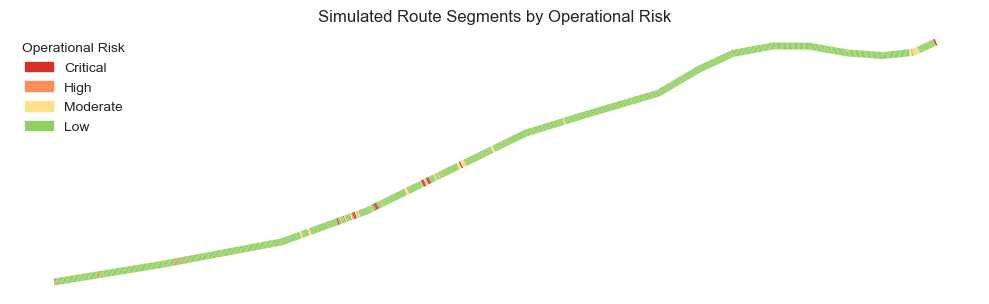

In [7]:
# Plot route segments colored by risk class
colors = {
    "Critical": "#d73027",
    "High": "#fc8d59",
    "Moderate": "#fee08b",
    "Low": "#91cf60"
}

fig, ax = plt.subplots(figsize=(10, 8))

# Plot lines
intersections.plot(ax=ax,
                   color=intersections["cell_complexity"].map(colors),
                   linewidth=5)

# Custom legend
legend_handles = [
    mpatches.Patch(color=colors[risk], label=risk)
    for risk in ["Critical", "High", "Moderate", "Low"]
]
ax.legend(handles=legend_handles, title="Operational Risk", loc="upper left")

# Final layout
plt.title("Simulated Route Segments by Operational Risk")
plt.axis("off")
plt.tight_layout()
os.makedirs("../outputs/plots", exist_ok=True)
plt.savefig("../outputs/plots/06_route_segments_by_risk.png", dpi=150)
plt.show()

In [9]:
# Export route segments
os.makedirs("../processed_data", exist_ok=True)
fname = f"../processed_data/06_route_segments_by_complexity.gpkg"
layer = f"06_route_segments_by_complexity"
intersections.to_file(fname, layer=layer, driver="GPKG")

print(f"Grid exported: {fname}")

Grid exported: ../processed_data/06_route_segments_by_complexity.gpkg
